# DEEP LEARNING OBJECT DETECTION FOR BALLISTIC EXPERIMENT ANALYSIS
MECE 687
Abraham Reyes Yanes

### Preparing the Environment

In [189]:
import cv2 
import numpy as np
import imutils
import time
import os
import pandas as pd
import numpy as np
import math
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns# ; sns.set()
from PIL import Image
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from IPython.display import clear_output
from datetime import datetime
import ipywidgets as widgets

### Checking Mask-RCNN

In [68]:
pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: c:\users\ur\anaconda3\envs\python-cvcourse\lib\site-packages\mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [69]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
import tensorflow as tf

Using TensorFlow backend.


In [70]:
class PredictionConfig(Config):
    NAME = "bullet_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [71]:
tf.logging.set_verbosity(tf.logging.ERROR)
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model_path = 'trained_models/box_bullet_2nd.h5'
model.load_weights(model_path, by_name=True)

### Extracting Images from video

In [133]:
dirname_project = 'Project_Bullet'
os.mkdir(dirname_project)

In [134]:
dirname_frameoutputs = 'Project_Bullet/1_frame_outputs/'
os.mkdir(dirname_frameoutputs)

In [135]:
startTime = datetime.now()
video= 'videos/TEST5.avi'
camera = cv2.VideoCapture(video)
length = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
i=1
while True:
    res, frame = camera.read()
    if not res:
        False
        break
    cv2.imwrite(os.path.join(dirname_frameoutputs,'frame_%i.jpg'%i),frame)
    i=i+1
    if cv2.waitKey(110) & 0xff == 27:
        break 
print(datetime.now() - startTime)

0:00:16.700283


In [136]:
for filename in os.listdir(dirname_frameoutputs):
    prefix, num = filename[:-4].split('_')
    num = num.zfill(6)
    new_filename = prefix + "_" + num + ".jpg"
    os.rename(os.path.join(dirname_frameoutputs, filename), os.path.join(dirname_frameoutputs, new_filename))

### Testing the model in one image

241 87 304 106


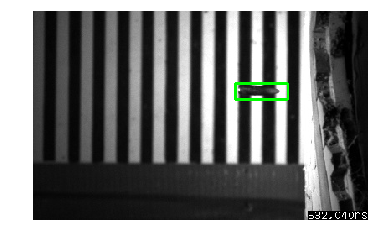

In [137]:
name = 'frame_000020.jpg'
path = os.path.join(dirname_frameoutputs,name)
image=plt.imread(path)
scaled_image = mold_image(image, cfg)
sample = expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)[0]
box = yhat['rois']
y1, x1, y2, x2 = box[0]
width, height = x2 - x1, y2 - y1
cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(image)
plt.axis('off')
print(x1,y1,x2,y2)

### Predicting bullet location

In [152]:
startTime = datetime.now()
path = dirname_frameoutputs
list_files=[f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))]
list_files= sorted(list_files)
num_files = len(list_files)
roi_matrix=np.zeros((num_files,4), dtype=int)
i=0
found=0
for filename in list_files:
    image=plt.imread(os.path.join(path, filename))
    scaled_image = mold_image(image, cfg)
    sample = expand_dims(scaled_image, 0)
    yhat = model.detect(sample, verbose=0)[0]
    box = yhat['rois']
    if not box.size >0:
        i=i+1
        clear_output()
        print("{} not found - {}".format(i,num_files))
        continue
    y1, x1, y2, x2 = box[0]
    width, height = x2 - x1, y2 - y1
    roi_matrix[i][0]= x1
    roi_matrix[i][1]= y1
    roi_matrix[i][2]= width
    roi_matrix[i][3]= height
    i=i+1
    clear_output()
    print("{} - {}".format(i,num_files))
    found=found+1
    if i == num_files:
        break
np.savetxt(os.path.join(dirname_project,"roi_matrix_predicted.csv"),roi_matrix, delimiter=",")
clear_output()
print("{} found of {} frames".format(found,num_files))
time_detection = datetime.now() - startTime
print(datetime.now() - startTime)

24 found of 128 frames
0:06:11.475132


In [153]:
display(roi_matrix)

array([[107,  87,  76,  16],
       [114,  86,  71,  17],
       [121,  84,  73,  21],
       [116,  83,  87,  20],
       [126,  85,  86,  17],
       [144,  84,  66,  19],
       [147,  84,  70,  23],
       [152,  85,  75,  21],
       [160,  86,  80,  22],
       [170,  86,  65,  19],
       [173,  86,  72,  17],
       [179,  85,  74,  18],
       [179,  86,  92,  21],
       [199,  86,  70,  18],
       [204,  85,  67,  19],
       [211,  86,  70,  17],
       [209,  86,  78,  18],
       [218,  87,  82,  21],
       [228,  87,  70,  16],
       [241,  87,  63,  19],
       [240,  88,  77,  18],
       [242,  87,  83,  20],
       [251,  88,  79,  19],
       [264,  87,  72,  22],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,  

### Calculating new ROI's

In [154]:
roi_data = pd.read_csv(os.path.join(dirname_project, "roi_matrix_predicted.csv"),header=None,names=['X', 'Y','W','H']).astype(int)
roi_data.head()

,X,Y,W,H
0,107,87,76,16
1,114,86,71,17
2,121,84,73,21
3,116,83,87,20
4,126,85,86,17


In [155]:
roi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 4 columns):
X    128 non-null int32
Y    128 non-null int32
W    128 non-null int32
H    128 non-null int32
dtypes: int32(4)
memory usage: 2.1 KB


In [156]:
image = plt.imread(os.path.join(dirname_frameoutputs, "frame_000001.jpg"))
height,width,channels= image.shape

In [160]:
startTime = datetime.now()
path = dirname_frameoutputs
list_files=[f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))]
num_files = len(list_files)
data_analysis = np.full((num_files,11),np.nan,dtype=float) # time,x,y,width,height,length,cx,angle,distance traveled, relative velocity per 2 frames,total velocity
i = 0
found=0
offset_x = 50
offset_y = 60
for filename in list_files:
    x_roi = roi_data['X'][i]
    y_roi = roi_data['Y'][i]
    w_roi = roi_data['W'][i]
    h_roi = roi_data['H'][i]
    if  roi_data['W'][i] == 0 :
        print("{} not found".format(i))
        i=i+1
        continue
    if w_roi < 60 :
        i=i+1
        continue
    if x_roi + int(w_roi/2) + 2*offset_x >= width:
        i=i+1
        continue
    if x_roi + int(w_roi/2) - offset_x <= 0:
        i=i+1
        continue
    data_analysis[i][1] = x_roi + (int(w_roi/2)) - offset_x
    data_analysis[i][2] = y_roi + (int(h_roi/2)) - offset_y
    data_analysis[i][3] = 2*offset_x
    data_analysis[i][4] = 2*offset_y
    clear_output()
    print("{} - {}".format(i,num_files))
    i=i+1 
    found=found+1
    if i == num_files:
        break
clear_output()
print("{} roi's of {} frames".format(found,num_files))
time_scaling_roi = datetime.now() - startTime
print(datetime.now() - startTime)

23 roi's of 128 frames
0:00:00.085772


### Creating ROI's

In [159]:
dirname_roioutputs = 'Project_Bullet/2_roi_outputs'
os.mkdir(dirname_roioutputs)

In [161]:
startTime = datetime.now()
from_path = dirname_frameoutputs
dest_path = dirname_roioutputs
list_files=[f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
num_files = len(list_files)
i = 0
found=0
for filename in list_files:
    # reading image
    image = plt.imread(os.path.join(from_path, filename))
    prefix, num = filename[:-4].split('_')
    position = num
    position = int(re.sub("^0+","",position))
    _,x1,y1,w,h,_,_,_,_,_,_ = data_analysis[position - 1]
  
    if  np.isnan(w)  :
        print("{} not found".format(i))
        clear_output()
        i=i+1
        continue
    roi = image[int(y1):int(y1 + h),int(x1):int(x1 + w)]
    new_filename ="roi" + "_" + num + ".jpg"
    cv2.imwrite(os.path.join(dest_path ,new_filename),roi)
    clear_output()
    print("{} - {}".format(i,num_files))
    i=i+1 
    found=found+1
    if i == num_files:
        break
clear_output()
print("{} roi's of {} frames".format(found,num_files))
time_cropping_roi = datetime.now() - startTime
print(datetime.now() - startTime)

23 roi's of 128 frames
0:00:00.957679


### Filtering Images

In [162]:
dirname_maskoutputs = 'Project_Bullet/3_mask_outputs'
os.mkdir(dirname_maskoutputs)

In [163]:
dirname_contoursoutputs = 'Project_Bullet/4_contours_outputs'
os.mkdir(dirname_contoursoutputs)

In [164]:
dirname_drewoutputs = 'Project_Bullet/5_drew_outputs'
os.mkdir(dirname_drewoutputs)

#### Filters Parameters

In [165]:
# Gaussian Blur
n_gaussian = 3
# Bilateral Blur
bilateral_diameter = 12
# Bright Correction
bright_gamma = 8                             
# Canny Detection
canny_sigma = 2.2
# Gradient 
n_gradient = 6
# Dilating
n_dilating = 3
# Clossing
f_closing = 12
n_closing = 10
# Erosion
it_erosion = 1
n_erosion = 1
# Smoothing
f_smooth = 10
n_smooth = 4
# Threshoold
low_thresh = 127
high_thresh = 255

In [190]:
### widgets
caption = widgets.Label(value='The values of slider1 and slider2 are synchronized')
ngaussian_updated = widgets.IntSlider(value=n_gaussian,min=0,max=15,step=2,description='N Gaussian:')
n_gaussian = ngaussian_updated.value
dbilateral_updated = widgets.IntSlider(value=bilateral_diameter,min=8,max=20,step=1,description='D Bilateral:')
gbright_updated = widgets.IntSlider(value=bright_gamma,min=6,max=20,step=1,description='G Brightness:')
scanny_updated = widgets.FloatSlider(value=canny_sigma,min=.5,max=3,step=.1,description='S Canny:')
ngradient_updated = widgets.IntSlider(value=n_gradient,min=2,max=10,step=1,description='N Gradient:')
ndilatation_updated = widgets.IntSlider(value=n_dilating,min=1,max=9,step=1,description='N Dilatation:')
fclosing_updated = widgets.IntSlider(value=f_closing,min=8,max=20,step=1,description='F Closing:')
nclosing_updated = widgets.IntSlider(value=n_closing,min=2,max=12,step=1,description='N Closing:')
iterosion_updated = widgets.IntSlider(value=it_erosion,min=1,max=6,step=1,description='IT Erosion:')
nerosion_updated = widgets.IntSlider(value=n_erosion,min=1,max=6,step=1,description='N Erosion:')
fsmooth_updated = widgets.IntSlider(value=f_smooth,min=6,max=16,step=1,description='F Smooth:')
nsmooth_updated = widgets.IntSlider(value=n_smooth,min=2,max=8,step=1,description='N Smooth:')
threshoold_updated = widgets.IntRangeSlider(value=[low_thresh,high_thresh],min=0,max=255,step=1,description='Threshoold:')
button_update = widgets.Button(description='Update Variables')
output = widgets.Output()
display(caption,ngaussian_updated,dbilateral_updated,gbright_updated,scanny_updated,ngradient_updated,ndilatation_updated,
        fclosing_updated,nclosing_updated,iterosion_updated,nerosion_updated,fsmooth_updated,nsmooth_updated,threshoold_updated
       ,button_update)
button_update.on_click(update_variables)

Label(value='The values of slider1 and slider2 are synchronized')

IntSlider(value=3, description='N Gaussian:', max=15, step=2)

IntSlider(value=12, description='D Bilateral:', max=20, min=8)

IntSlider(value=8, description='G Brightness:', max=20, min=6)

FloatSlider(value=2.2, description='S Canny:', max=3.0, min=0.5)

IntSlider(value=6, description='N Gradient:', max=10, min=2)

IntSlider(value=3, description='N Dilatation:', max=9, min=1)

IntSlider(value=12, description='F Closing:', max=20, min=8)

IntSlider(value=10, description='N Closing:', max=12, min=2)

IntSlider(value=1, description='IT Erosion:', max=6, min=1)

IntSlider(value=1, description='N Erosion:', max=6, min=1)

IntSlider(value=10, description='F Smooth:', max=16, min=6)

IntSlider(value=4, description='N Smooth:', max=8, min=2)

IntRangeSlider(value=(127, 255), description='Threshoold:', max=255)

Button(description='Update Variables', style=ButtonStyle())

NameError: name 'update_variables' is not defined

#### Testing Filters

#### Apply Filters, Calculating Countours, Cx and derivations

['roi_000016.jpg', 'roi_000002.jpg', 'roi_000020.jpg', 'roi_000005.jpg', 'roi_000018.jpg']


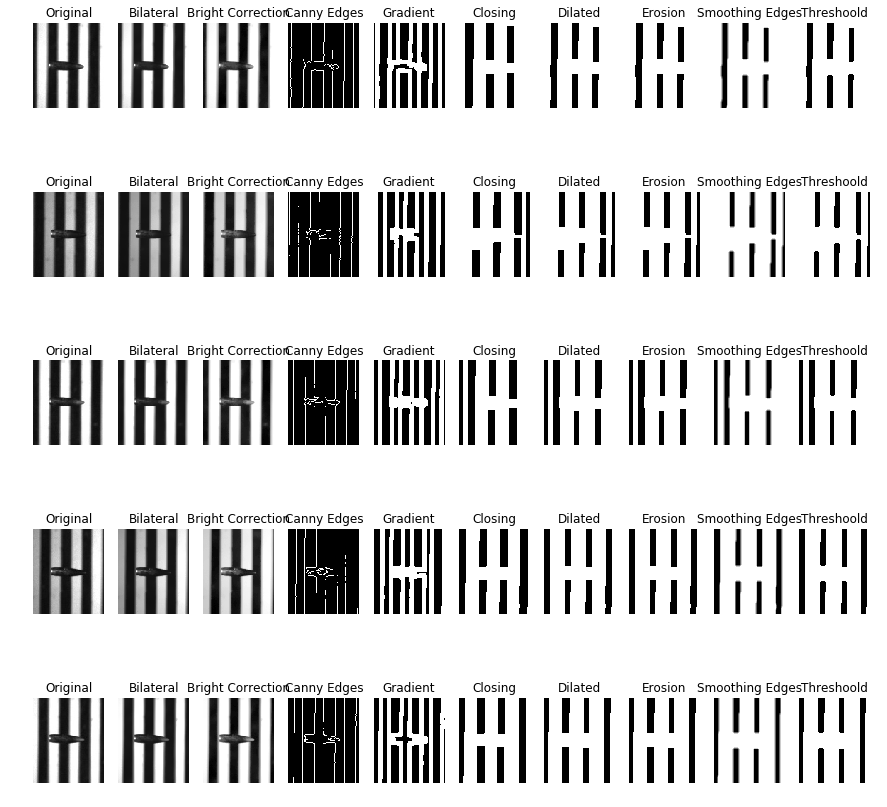

In [166]:
startTime = datetime.now()
from_path = dirname_roioutputs
list_files= [f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
random.shuffle(list_files)
list_files = list_files[0:5]
num_files = len(list_files)
fig, axs = plt.subplots(5,10,figsize=(15,15))
i = 0
for filename in list_files:
    
    image = cv2.imread(os.path.join(from_path,filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i, 0].imshow(image,cmap ='gray')
    axs[i, 0].set_title('Original')
    axs[i, 0].set_axis_off()
    
    bilateral_stdcolor = bilateral_diameter*2
    bilateral_stdspace = bilateral_diameter/2
    roi_blur = cv2.bilateralFilter(image,bilateral_diameter,bilateral_stdcolor,bilateral_stdspace)
    axs[i, 1].imshow(roi_blur,cmap ='gray')
    axs[i, 1].set_title('Bilateral')
    axs[i, 1].set_axis_off()

    roi_bright = np.power(roi_blur,1/bright_gamma)
    roi_corrected = np.array(roi_bright*255, dtype = np.uint8)
    roi_corrected = cv2.cvtColor(roi_corrected, cv2.COLOR_RGB2GRAY)
    axs[i, 2].imshow(roi_corrected,cmap ='gray')
    axs[i, 2].set_title('Bright Correction')
    axs[i, 2].set_axis_off()

    v = np.median(roi_corrected)
    lower = int(max(0, (1.0 - canny_sigma) * v))
    upper = int(min(255, (1.0 + canny_sigma) * v))
    edges = cv2.Canny(roi_corrected, lower, upper)
    axs[i, 3].imshow(edges,cmap ='gray')
    axs[i, 3].set_title('Canny Edges')
    axs[i, 3].set_axis_off()

    kernel_g = np.ones((n_gradient,n_gradient),np.uint8)
    gradient = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel_g)
    axs[i, 4].imshow(gradient,cmap ='gray')
    axs[i, 4].set_title('Gradient')
    axs[i, 4].set_axis_off()

    kernel_c = np.ones((n_closing,n_closing),np.uint8)*f_closing
    closing = cv2.morphologyEx(gradient, cv2.MORPH_CLOSE, kernel_c)
    axs[i, 5].imshow(closing,cmap ='gray')
    axs[i, 5].set_title('Closing')
    axs[i, 5].set_axis_off()

    kernel_d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(n_dilating,n_dilating))   
    dilated = cv2.dilate(closing, kernel_d)
    axs[i, 6].imshow(dilated,cmap ='gray')
    axs[i, 6].set_title('Dilated')
    axs[i, 6].set_axis_off()

    kernel_e = np.ones((n_erosion,n_erosion),np.uint8)
    erosion = cv2.erode(dilated,kernel_e,iterations = it_erosion)
    axs[i, 7].imshow(erosion,cmap ='gray')
    axs[i, 7].set_title('Erosion')
    axs[i, 7].set_axis_off()

    kernel = np.ones((n_smooth,n_smooth),np.float32)/f_smooth
    smooth = cv2.filter2D(erosion,-1,kernel)
    axs[i, 8].imshow(smooth,cmap ='gray')
    axs[i, 8].set_title('Smoothing Edges')
    axs[i, 8].set_axis_off()

    ret,roi_thresh = cv2.threshold(smooth,low_thresh,high_thresh,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    axs[i, 9].imshow(roi_thresh,cmap ='gray')
    axs[i, 9].set_title('Threshoold')
    axs[i, 9].set_axis_off()

    i=i+1   
    if i == num_files +1:
        break
for ax in axs.flat:
    ax.label_outer()

print(list_files)
plt.show()



In [167]:
startTime = datetime.now()
from_path = dirname_roioutputs
mask_path = dirname_maskoutputs
contour_path = dirname_contoursoutputs
drew_path = dirname_drewoutputs
list_files=[f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
num_files = len(list_files)
i = 0
for filename in list_files:
    image = cv2.imread(os.path.join(from_path, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
###APPLYING FILTERs
    #roi_blur = cv2.GaussianBlur(image,(n_gaussian,n_gaussian),0,0)
    bilateral_stdcolor = bilateral_diameter*2
    bilateral_stdspace = bilateral_diameter/2
    roi_blur = cv2.bilateralFilter(image,bilateral_diameter,bilateral_stdcolor,bilateral_stdspace)
    # APPLYING BRIGHT CORRECTION
    roi_bright = np.power(roi_blur,1/bright_gamma)
    roi_corrected = np.array(roi_bright* 255, dtype = np.uint8)
    roi_corrected = cv2.cvtColor(roi_corrected, cv2.COLOR_RGB2GRAY)
    # Canny edges
    v = np.median(roi_corrected)
    lower = int(max(0, (1.0 - canny_sigma) * v))
    upper = int(min(255, (1.0 + canny_sigma) * v))
    edges = cv2.Canny(roi_corrected, lower, upper)
    # Gradient to close contour
    kernel_g = np.ones((n_gradient,n_gradient),np.uint8)
    gradient = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel_g)
    # Clossing to remove internal noise
    kernel_c = np.ones((n_closing,n_closing),np.uint8)*f_closing
    closing = cv2.morphologyEx(gradient, cv2.MORPH_CLOSE, kernel_c)
    # Dilating the edges to strenght edges
    kernel_d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(n_dilating,n_dilating))
    dilated = cv2.dilate(closing, kernel_d)  
    #Applying Erosion for smoothing edges
    kernel_e = np.ones((n_erosion,n_erosion),np.uint8)
    erosion = cv2.erode(dilated,kernel_e,iterations = it_erosion)
    #APPLYING SMOOTHING
    kernel = np.ones((n_smooth,n_smooth),np.float32)/f_smooth
    smooth = cv2.filter2D(erosion,-1,kernel)
    # Applying Threshold
    ret,roi_thresh = cv2.threshold(smooth,low_thresh,high_thresh,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Saving File
    prefix, num = filename[:-4].split('_')
    position = num
    position = int(re.sub("^0+","",position))
    new_filename_mask ="mask" + "_" + num + ".jpg"
    cv2.imwrite(os.path.join(mask_path,new_filename_mask),roi_thresh)
### FINDING CONTOURS
    contour_img = image.copy()
    items = cv2.findContours(roi_thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = items[0] if len(items) == 2 else items[1]
    cv2.drawContours(contour_img,contours,-1, (0, 255, 0), 2) 
    new_filename_contour ="contours" + "_" + num + ".jpg"
    cv2.imwrite(os.path.join(contour_path,new_filename_contour),contour_img)
    ### GETTING AREA
    c = max(contours, key=cv2.contourArea)
    M = cv2.moments(c)
    area = cv2.contourArea(c)
    #data_analysis[position - 1][4]= area
### GETTING CENTROID and Bounding Box
    # determine the most extreme points along the contour
    line_img = image.copy()
    extLeft = tuple(c[c[:,:, 0].argmin()][0])
    extRight = tuple(c[c[:,:, 0].argmax()][0])
    extTop = tuple(c[c[:,:, 1].argmin()][0])
    extBot = tuple(c[c[:,:, 1].argmax()][0])
    # where extLeft is the farthest point at the left(tip of the bullet)
    x_left = extLeft[0]
    x_right = extRight[0]
    y_bottom = extBot[1]
    y_top = extTop[1]
    cv2.rectangle(line_img,(x_left,y_bottom),(x_right,y_top),(0,255,0),2)
### GETTING LENGTH OF BULLET
    length  = abs(x_left - x_right)
    data_analysis[position - 1][5]= length
    #Calculating centroid
    cX = M["m10"] / M["m00"]
    cY = M["m01"] / M["m00"]
    centroid= (int(cX),int(cY))
    cv2.circle(line_img,centroid,1,(255,165,0),3) 
    #Saving centroid
    _,x1, y1, width, height,_,_,_,_,_,_ = data_analysis[position - 1]
    centroid_X_value = cX + x_roi
    data_analysis[position - 1][6]= centroid_X_value + x1
### DRAWING BOUNDING BOX AND LINES
    #Extending driven line
    m= ((line_img.shape[0]-extLeft[1])-(line_img.shape[0]-cY))/(extLeft[0]-cX)
    d= ((line_img.shape[0]-extLeft[1])+(-m*extLeft[0]))
    x_value=10
    dline_1 = (x_value,line_img.shape[0]-int((m*10)+d))
    dline_2 = (line_img.shape[1]-x_value,line_img.shape[0]-int((m*(line_img.shape[1]-10))+d))
    cv2.line(line_img,dline_1,dline_2,(255,0,0),1)                                     ### Pitch line
    cv2.line(line_img,(x_value,int(cY)),(line_img.shape[1]-x_value,int(cY)),(0,0,0),1) ### Reference line
    cv2.circle(line_img,extLeft,1,(255,165,0),3)
    new_filename_contour ="lines" + "_" + num + ".jpg"
    cv2.imwrite(os.path.join(drew_path,new_filename_contour),line_img)
### ANGLE AND DISTANCE TRAVELED
    ###Horizontal line
    dx_h= (extLeft[0]-int(cX))
    dy_h= int(cY)-int(cY)
    dist_hor = math.sqrt(math.pow(dx_h, 2)+math.pow(dy_h, 2))
    ###Pitch line
    dx_p=(extLeft[0]-int(cX))
    dy_p=((line_img.shape[0]-extLeft[1])-(line_img.shape[0]-cY))
    dist_pitch = math.sqrt(math.pow(dx_p, 2)+math.pow(dy_p, 2))
    ### Angle Calculation
    quotient = dist_hor/dist_pitch
    angle=np.arccos(quotient)
    angle = math.degrees(angle)
    data_analysis[position - 1][7] = angle
    ### Distance Travelled Calculation
    if i != 0 :
        data_analysis[position - 1][8] = abs(data_analysis[position - 2][6] - data_analysis[position - 1][6])      
    #Finishing
    clear_output()
    print("{} - {}".format(i,num_files))
    i=i+1 
    if i == num_files:
        break
clear_output()
plt.show()
print("{} of {} roi's".format(i,num_files))
time_filters_operations = datetime.now() - startTime
print(datetime.now() - startTime)

23 of 23 roi's
0:00:00.873409


#### Relative Velocity

In [180]:
startTime = datetime.now()
i = 0
for rows in data_analysis:
    #Pixel -m dimension
    average_length_pixels= np.nanmean(data_analysis[:,5])         #pixels
    #bullet_length = .02863                                       # m, 9mm
    bullet_length = .056                                          # m, AK47mm
    pixel_m = bullet_length/average_length_pixels
    fps = 2e6
    traveled_frames = 2
    traveled_seconds = traveled_frames/fps
    traveled_pixels =np.nansum(data_analysis[i,8])
    if i > 0 :
        data_analysis[i][0] = i/fps
    if traveled_pixels > 10 :
        relative_velocity = (pixel_m* traveled_pixels)/ traveled_seconds
        data_analysis[i][9] = relative_velocity
    #Finishing
    i=i+1 
time_relative_velocity = datetime.now() - startTime
print(datetime.now() - startTime)

0:00:00.010971


#### Total Relative Velocity

In [181]:
startTime = datetime.now()
traveled_pixels= np.nansum(data_analysis[:,8])
traveled_frames= data_analysis[:,7].size - np.count_nonzero(np.isnan(data_analysis[:,8]))
traveled_seconds= traveled_frames/fps
total_relative_velocity = (pixel_m * traveled_pixels) / traveled_seconds
data_analysis[0][10] = total_relative_velocity

print('Frames travelled = {0} '.format(traveled_frames) + 'frames')
print('Seconds travelled = {0} '.format(traveled_seconds) + 'seconds')
print('Total Relative Velocity = {0} '.format(total_relative_velocity) + 'm/s')
time_total_relative_velocity = datetime.now() - startTime
print(datetime.now() - startTime)

Frames travelled = 22 frames
Seconds travelled = 1.1e-05 seconds
Total Relative Velocity = 9819.780717896818 m/s
0:00:00.000996


In [182]:
np.savetxt(os.path.join(dirname_project,"data_analysis.csv"),data_analysis, delimiter=",",header='TIME,X,Y,WIDTH,HEIGHT,LENGHT,CX,ANGLE,TRAVELED DISTANCE,RELATIVE VELOCITY,TOTAL RELATIVE VELOCITY')

#### Exporting to final frame

In [171]:
dirname_annotated = 'Project_Bullet/6_annotated'
os.mkdir(dirname_annotated)

In [183]:
startTime = datetime.now()
from_path = dirname_frameoutputs
drew_path =  dirname_drewoutputs
dest_path = dirname_annotated
list_files=[f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
num_files = len(list_files)
### Defining values for letters
font= cv2.FONT_HERSHEY_SIMPLEX
i = 0
for filename in list_files:
    # reading image
    image = plt.imread(os.path.join(from_path, filename))
    image = image.copy()
    prefix, num = filename[:-4].split('_')
    position = num
    position = int(re.sub("^0+","",position))
    new_filename ="annotated" + "_" + num + ".jpg"
    if np.isnan(data_analysis[position - 1,4]) :
        cv2.imwrite(os.path.join(dest_path ,new_filename),image)
        i=i+1 
        continue
    t,x1,y1,w,h,l,cx,an,dt,rv,_ = data_analysis[position - 1] # x,y,width,height,length,cx,angle,distance traveled, relative velocity per 2 frames
    roi = plt.imread(os.path.join(drew_path, 'lines_'+ num+'.jpg'))
    image[int(y1):int(y1 + h),int(x1):int(x1 + w)] = roi
    try:
        cv2.putText(image,'Angle : {0:.2f}'.format(an) +' Degrees',(20,240),font,.5,(0, 0, 255),1)
        cv2.putText(image,'Rv: {0:.2f}'.format(rv) + ' m/s',(20,270),font,.5,(0, 0, 255),1)
    except Exception:
        pass
    cv2.putText(image,'Total Relative velocity : {0:.2f}'.format(data_analysis[0,10]) + ' m/s',(180,400),font,.6,(255, 0, 0),1)
    cv2.imwrite(os.path.join(dest_path ,new_filename),image)
    i=i+1
    if i == num_files:
        break
time_final_frame = datetime.now() - startTime
print(datetime.now() - startTime)

0:00:01.002366


#### Saving a New Video

In [173]:
image = plt.imread(os.path.join(dirname_frameoutputs, "frame_000001.jpg"))
height,width,channels= image.shape

In [174]:
startTime = datetime.now()
from_path = dirname_annotated
dest_path = dirname_project
list_files=[f for f in os.listdir(from_path)if os.path.isfile(os.path.join(from_path, f))]
list_files=sorted(list_files)
num_files = len(list_files)
fps = 9
filename= 'annotated_video.avi'
writer = cv2.VideoWriter(os.path.join(dest_path, filename),cv2.VideoWriter_fourcc(*"DIVX"),fps,(width, height))
i = 0
for filename in list_files:
    image = plt.imread(os.path.join(from_path, filename))
    time.sleep(1/fps)
    writer.write(image) 
    i=i+1
    if i == num_files:
        break
writer.release()
time_exporting = datetime.now() - startTime
print(datetime.now() - startTime)

0:00:18.042365


#### DATA ANALYSIS

In [184]:
data_analysis_table = pd.read_csv(os.path.join(dirname_project,'data_analysis.csv'))
data_analysis_table.head()

,# TIME,X,Y,WIDTH,HEIGHT,LENGHT,CX,ANGLE,TRAVELED DISTANCE,RELATIVE VELOCITY,TOTAL RELATIVE VELOCITY
0,NaN,95.0,35.0,100.0,120.0,54.0,137.987885,6.073956,NaN,NaN,9819.780718
1,5.000000e-07,99.0,34.0,100.0,120.0,96.0,144.180347,53.008759,6.192463,NaN,NaN
2,1.000000e-06,107.0,34.0,100.0,120.0,99.0,158.670696,15.020197,14.490349,9927.430553,NaN
3,1.500000e-06,109.0,33.0,100.0,120.0,81.0,167.247988,23.559608,8.577292,NaN,NaN
4,2.000000e-06,119.0,33.0,100.0,120.0,79.0,166.500428,23.668074,0.747561,NaN,NaN


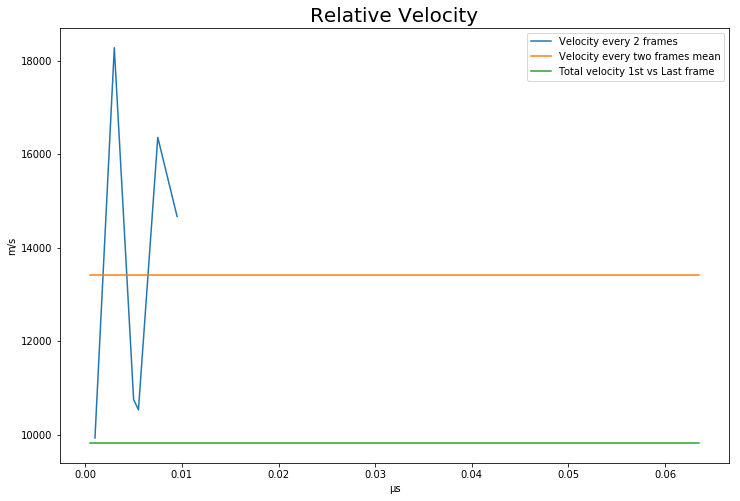

In [185]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['RELATIVE VELOCITY'])
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['RELATIVE VELOCITY'].mean())
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['TOTAL RELATIVE VELOCITY'][0])
plt.legend(['Velocity every 2 frames','Velocity every two frames mean','Total velocity 1st vs Last frame'])
plt.xlabel('μs')
plt.ylabel('m/s')
plt.title('Relative Velocity',fontsize = 20)
plt.savefig(os.path.join(dirname_project,'Relative Velocity.png'))

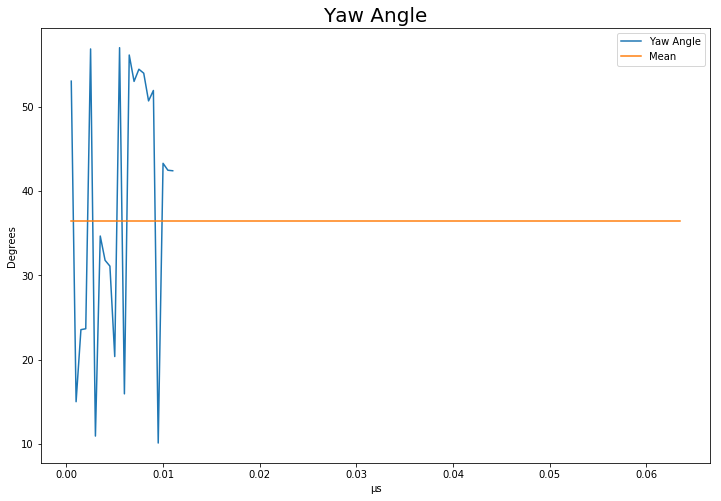

In [186]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['ANGLE'])
sns.lineplot(data_analysis_table['# TIME']*1000,data_analysis_table['ANGLE'].mean())
plt.legend(['Yaw Angle','Mean'])
plt.xlabel('μs')
plt.ylabel('Degrees')
plt.title('Yaw Angle',fontsize = 20)
plt.savefig(os.path.join(dirname_project,'Yaw Angle.png'))

In [132]:
timing_labels =['Detection time','ROI calculation','ROI cropping','Image processing','Calculations','Exporting']
timing_values =[time_detection.total_seconds(),time_scaling_roi.total_seconds(),time_cropping_roi.total_seconds(),time_filters_operations.total_seconds(),time_relative_velocity.total_seconds()+time_total_relative_velocity.total_seconds(),time_final_frame.total_seconds()]
times_elapsed = {'Step':timing_labels,'Seconds':timing_values}
times_dataframe = pd.DataFrame(times_elapsed)
times_dataframe.to_csv(os.path.join(dirname_project,'timing_analysis.csv'),index=False)
times_dataframe.head()

,Step,Seconds
0,Detection time,1311.383906
1,ROI calculation,0.141622
2,ROI cropping,1.082126
3,Image processing,1.789208
4,Calculations,0.005984
